## Upegning af steder med langsom trafik i Aarhus - Demo til Kortdage 2018

Demonstrationen tager udgangspunkt i offentligt tilgængelige data fra:

Trafikdata fra Aarhus Kommune via `opendata.dk`

Urban Atlas fra `European Environment Agency` (EEA)

Vejdata fra GeoDanmark via `Kortforsyningen`

De primære værktøjer som anvendes er [Pandas](http://pandas.pydata.org/pandas-docs/stable/) og [GeoPandas](http://geopandas.org/).

In [55]:
%matplotlib inline

In [56]:
import os
import pandas as pd
import geopandas
import pyproj
import matplotlib.pyplot as plt
import psycopg2

# set standart størrelse på figure
plt.rcParams['figure.figsize'] = (12, 12)

### FIX til pyproj

Det ser ud til at nogle versioner af Anaconda har problemer med nogle miljøvariable

https://github.com/geopandas/geopandas/issues/830#issuecomment-426116505

In [57]:
os.environ["PROJ_LIB"] = 'C:\ProgramData\Anaconda3\Library\share'
pyproj.set_datapath = 'C:\ProgramData\Anaconda3\Library\share'
print(pyproj.datadir)

<module 'pyproj.datadir' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\pyproj\\datadir.py'>


# indlæsning af data

**Urban Atlas** viser byer i europa, indelt i forskellige arealtyper og er donwloaded fra (http://www.eea.europa.eu/data-and-maps/data/urban-atlas)


In [58]:
## OBS! download selv data fra ovenstpende link, da filen er for stor til Github.
data = geopandas.read_file('data/Shapefiles/DK002L1_ARHUS_UA2012.shp', bbox=(4320000,3660000,4340000,3680000))

Man kan også "slice" i data, efterefølgende via cx

fx:

data = data.cx[4320000:4340000,3660000:3680000]

Den angivne projection kan ses via .crs, og transformeres via .to_crs()

Der kan også være behov for manuelt, at angive hvilken projektion data har via .crs = {'init' :'epsg:1234'} 

In [59]:
print(data.crs)
data = data.to_crs(epsg=25832)
print(data.crs)

data.head()

{'proj': 'laea', 'lat_0': 52, 'lon_0': 10, 'x_0': 4321000, 'y_0': 3210000, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}
{'init': 'epsg:25832', 'no_defs': True}


COUNTRY CITIES FUA_OR_CIT CODE2012                                ITEM2012  \
0      DK  Århus    DK002L1    11100  Continuous urban fabric (S.L. : > 80%)   
1      DK  Århus    DK002L1    11100  Continuous urban fabric (S.L. : > 80%)   
2      DK  Århus    DK002L1    11100  Continuous urban fabric (S.L. : > 80%)   
3      DK  Århus    DK002L1    11100  Continuous urban fabric (S.L. : > 80%)   
4      DK  Århus    DK002L1    11100  Continuous urban fabric (S.L. : > 80%)   

  PROD_DATE       IDENT   Shape_Leng    Shape_Area  \
0      2016  54-DK002L1   296.979001   4589.259444   
1      2016  55-DK002L1  2851.378857  50755.953916   
2      2016  56-DK002L1   350.184523   5979.091111   
3      2016  57-DK002L1   441.731006   8989.908429   
4      2016  60-DK002L1   610.161517  14391.116436   

                                            geometry  
0  POLYGON ((575711.7971863004 6212651.535146947,...  
1  POLYGON ((575653.7656616532 6212985.201172531,...  
2  POLYGON ((561330.5026668725 6213171.102654113,...  
3  POLYGON ((561318.2932078685 6213245.39207912, ...  
4  POLYGON ((572529.1347126649 6214483.179431625,...

In [60]:
list(data.ITEM2012.unique())

['Continuous urban fabric (S.L. : > 80%)',
 'Discontinuous dense urban fabric (S.L. : 50% -  80%)',
 'Discontinuous medium density urban fabric (S.L. : 30% - 50%)',
 'Discontinuous low density urban fabric (S.L. : 10% - 30%)',
 'Discontinuous very low density urban fabric (S.L. : < 10%)',
 'Isolated structures',
 'Industrial, commercial, public, military and private units',
 'Port areas',
 'Mineral extraction and dump sites',
 'Construction sites',
 'Land without current use',
 'Green urban areas',
 'Sports and leisure facilities',
 'Arable land (annual crops)',
 'Pastures',
 'Forests',
 'Herbaceous vegetation associations (natural grassland, moors…)',
 'Water',
 'Other roads and associated land',
 'Railways and associated land',
 'Fast transit roads and associated land']

Arealerne kan returneres via:

In [61]:
data.geometry.area

0        4586.233451
1       50722.487687
2        5974.859269
3        8983.547578
4       14381.459246
5        5733.581227
6        2489.448860
7        3016.630445
8        3520.029781
9        7535.128869
10       1155.696080
11      33823.775011
12       7232.762964
13       3094.936284
14       3566.375626
15      59369.518997
16      20302.750449
17       2966.661335
18      24712.407610
19      28919.369814
20       2540.832260
21       7605.935885
22       1520.665939
23       3333.306243
24      18907.956109
25      10390.742792
26      10742.102791
27       7470.454548
28      16691.807512
29       2646.634000
            ...     
7964    28712.188051
7965      105.548652
7966    22443.081439
7967    25272.275959
7968      136.738582
7969     4972.239839
7970      386.849738
7971      375.896149
7972      149.143889
7973    96822.118829
7974       96.539377
7975      195.781760
7976      856.155871
7977    57936.309962
7978      855.723662
7979      101.597041
7980     5144

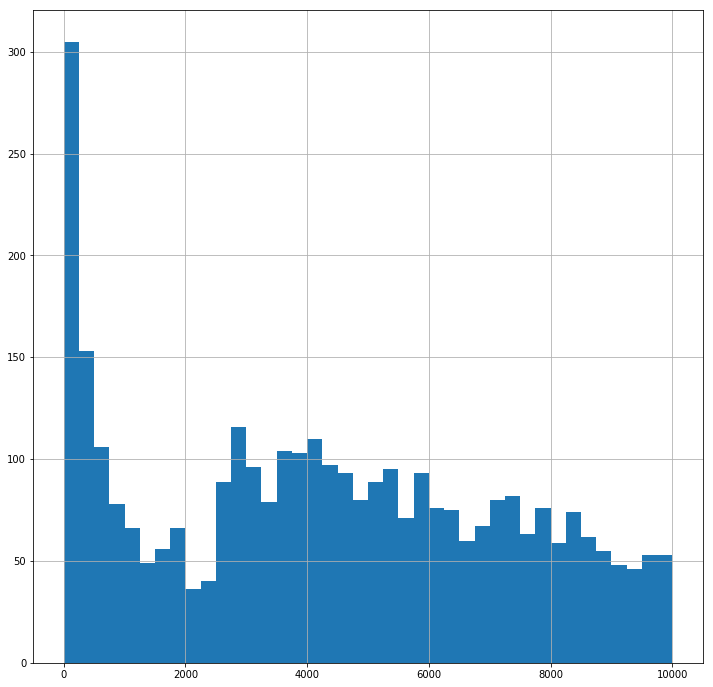

In [62]:
data.geometry.area.hist(bins=40, range=(0,10000))

Antal ugyldige geometrier: 4


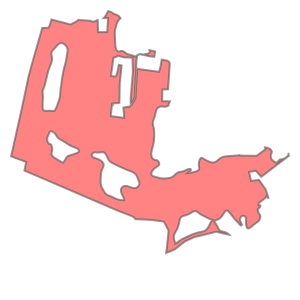

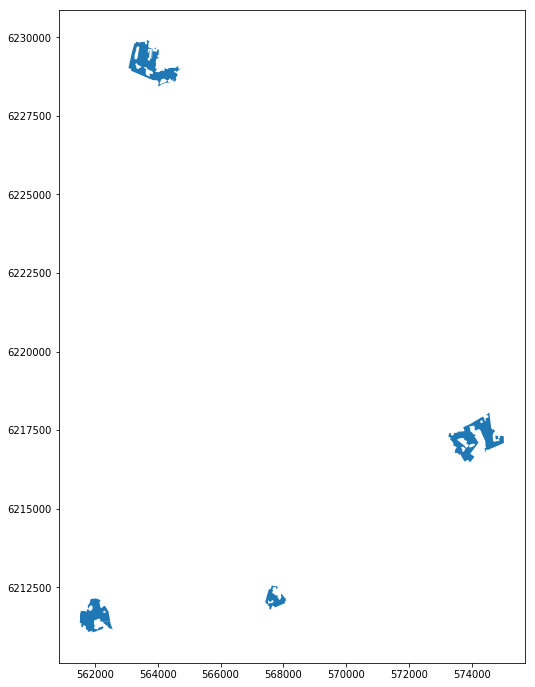

In [63]:
invalid = data.geometry[data.is_valid == False]
print('Antal ugyldige geometrier:', invalid.size)

# plot alle ugyldige geometrier
invalid.plot(figsize=(12,12))

# plot enkelt ugyldig geometri
invalid.iloc[3]


In [64]:
bounds = data.total_bounds 
bounds

array([ 559569.94779635, 6209497.74071215,  580976.74631613,
       6233305.70647184])

In [65]:
data = data[data['ITEM2012'] != 'Water']

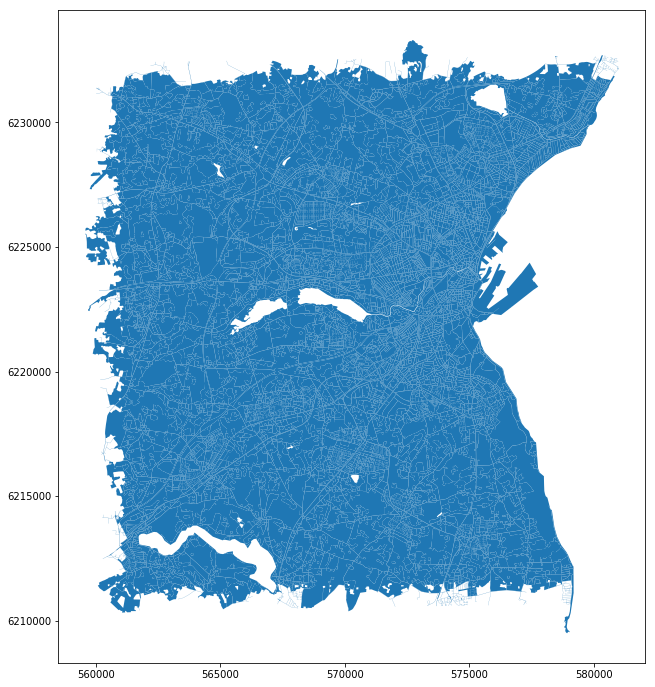

In [66]:
data.plot()
plt.savefig('aarhus_map_blue.svg')

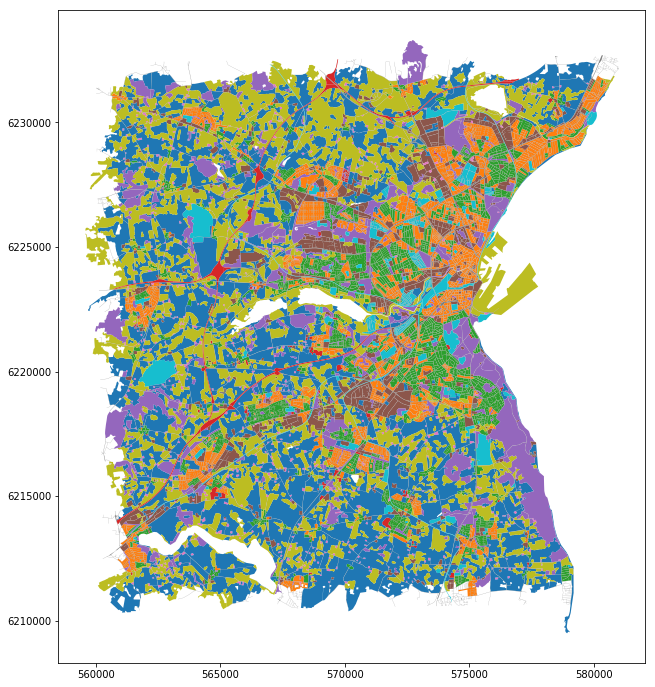

In [67]:
data.plot(column='ITEM2012')
plt.savefig('aarhus_map_categorized.svg')

In [68]:
road_list = (data['ITEM2012'] == 'Other roads and associated land') | \
(data['ITEM2012'] == 'Fast transit roads and associated land')

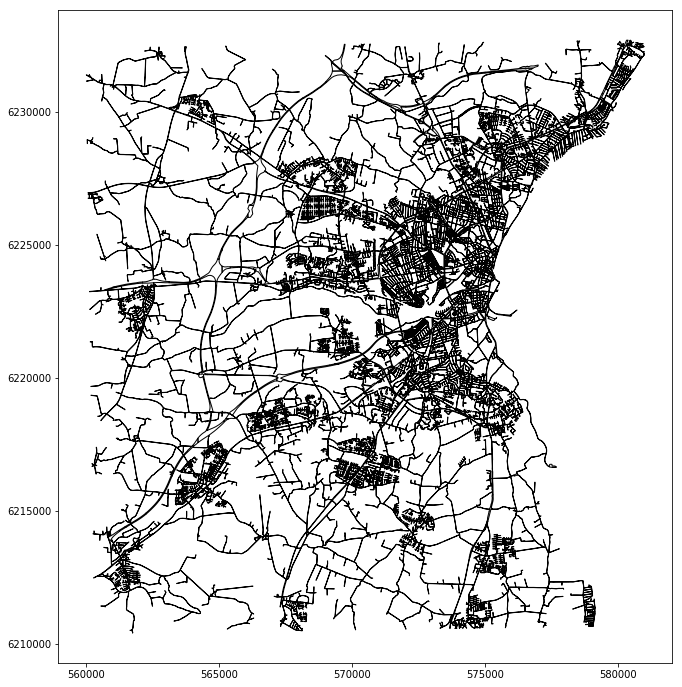

In [69]:
roads = data[road_list]
plot_roads = roads.plot(color='none', edgecolor='black')

# Hent vejdata fra SDFE (linjer)
data er et udsnit af fot_vejmidte 

# Hvor opstår der trafikpropper?

a) Dagligt gennemsnits af hastighed per sensor 

b) find største daglige avigelse (største afstand fra gennemsnittet)

c) visualiser afvigelserne med fokus på nedsat hastighed


Noter (brug evt gennemsnit over længere periode per ugedage / weekender / individuelle dage)

In [98]:
trafic_data = pd.read_csv('trafic_data.csv', index_col=0)


In [99]:
trafic_data.TIMESTAMP = pd.to_datetime(trafic_data.TIMESTAMP)
trafic_data.head()

_id  REPORT_ID           TIMESTAMP status  avgMeasuredTime  \
0  205     181223 2018-10-30 00:02:00     OK               65   
1  224     192653 2018-10-30 00:02:00     OK               32   
2  230     180655 2018-10-30 00:02:00     OK               69   
3  328     179336 2018-10-30 00:02:00     OK               49   
4  193     179256 2018-10-30 00:02:00     OK               34   

   medianMeasuredTime  vehicleCount  avgSpeed  
0                  65             1        29  
1                  32             0        69  
2                  69             0        47  
3                  49             1        66  
4                  34             0        64

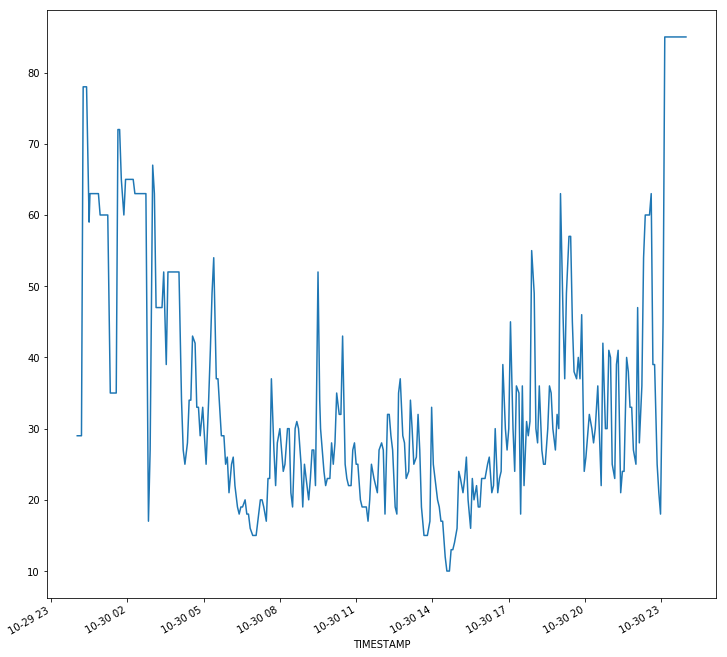

In [100]:
trafic_data[trafic_data._id == 205].set_index('TIMESTAMP').avgSpeed.plot()
plt.savefig('sensor_205.svg')

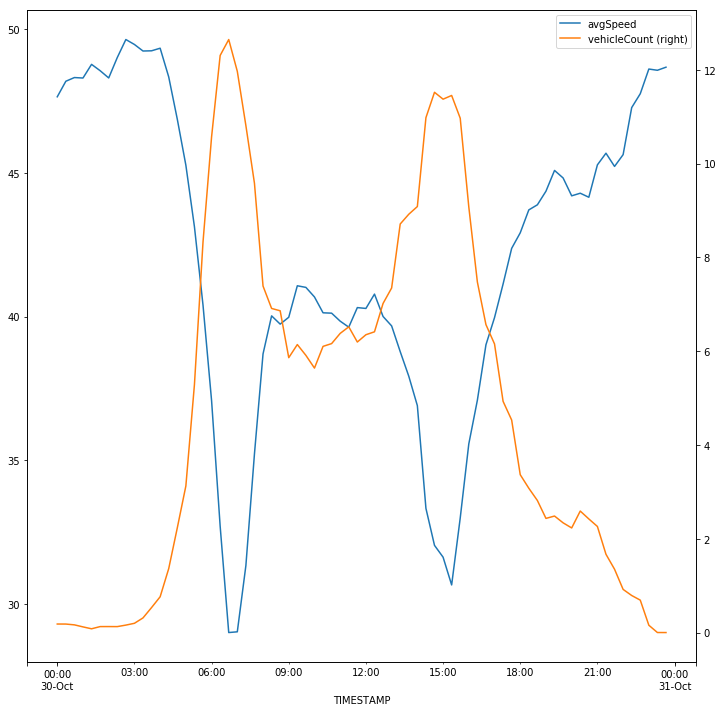

In [101]:
r = trafic_data.set_index('TIMESTAMP').resample('20Min')
r.mean().avgSpeed.plot(legend=True)
r.mean().vehicleCount.plot(secondary_y='vehicleCount',legend=True)
plt.savefig('sensor_205_re_20min.svg')

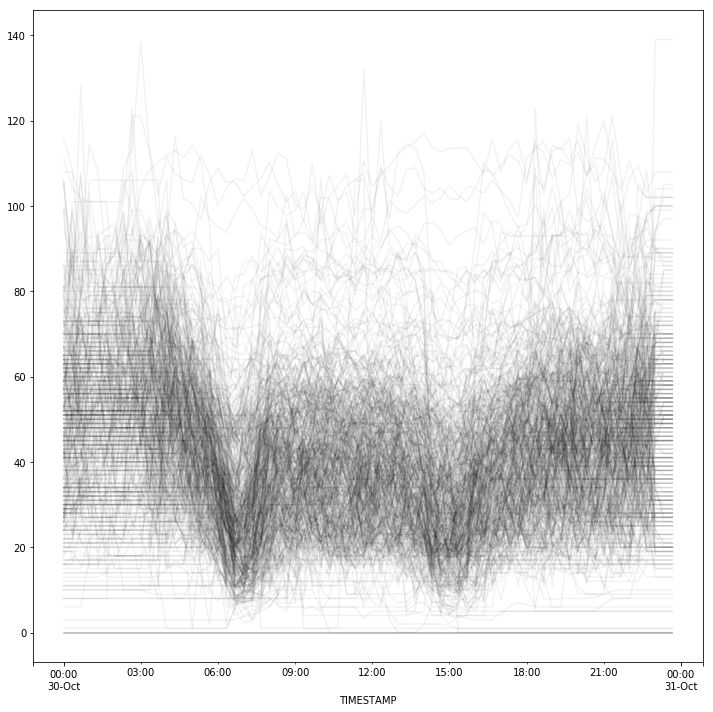

In [102]:
#trafic_data.groupby(pd.Grouper(key='TIMESTAMP', freq='1h'))
#grouper = trafic_data.groupby([pd.Grouper('1H'), '_id'])
grouped = trafic_data.set_index('TIMESTAMP').groupby(['_id', pd.Grouper(freq='20min')])['vehicleCount','avgSpeed'].mean()
grouped.unstack('_id').avgSpeed.plot(alpha=0.05, color='k', legend=False)
#grouped.plot('_id')
plt.savefig('sensor_all.svg')

In [103]:
grouped = grouped[(grouped.avgSpeed > 0) & (grouped.vehicleCount > 0)]

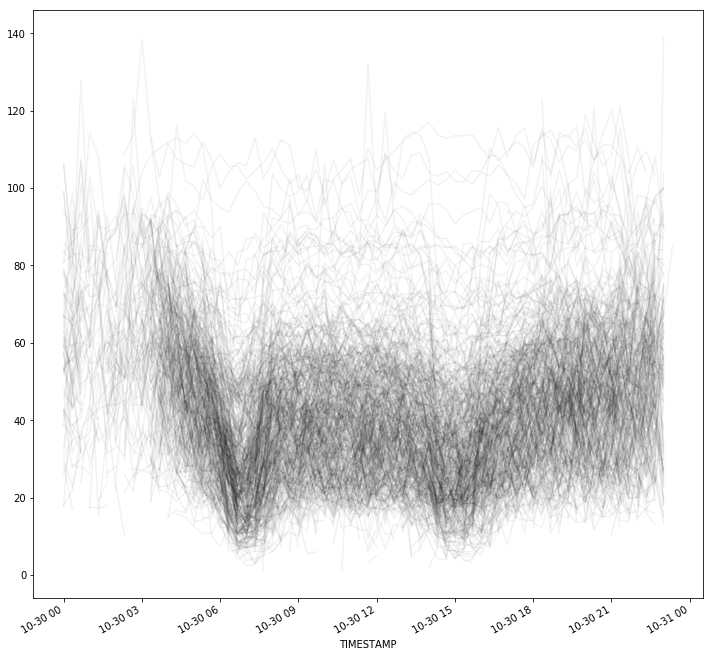

In [104]:
#grouped.plot()
grouped.unstack('_id').avgSpeed.plot(alpha=0.05, color='k', style='-', legend=False)
plt.savefig('sensor_all_filtered.svg')

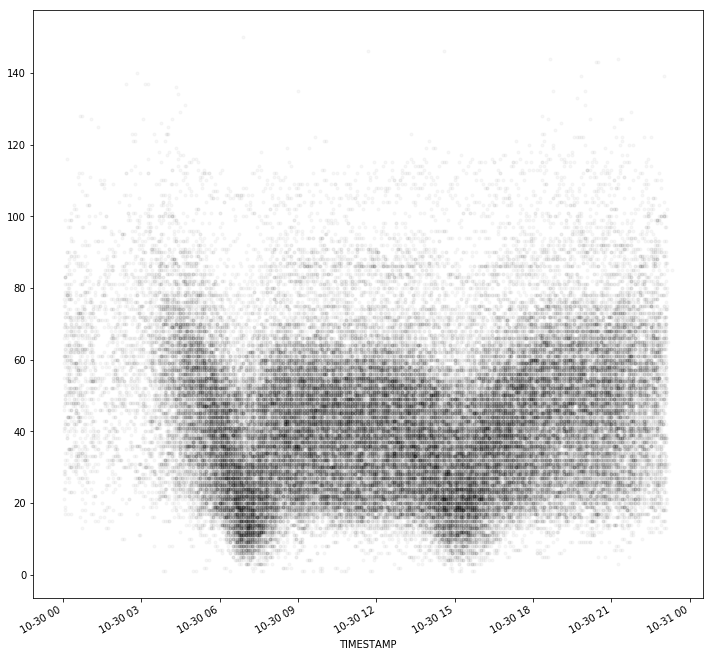

In [81]:
trafic_data[(trafic_data.avgSpeed > 0) & (trafic_data.vehicleCount > 0)].set_index('TIMESTAMP').avgSpeed.plot(alpha=0.03, color='k', style='.', legend=False)

In [106]:
slow_down = grouped.groupby('_id').mean()
slow_down.vehicleCount = grouped.groupby('_id').vehicleCount.sum()
slow_down['minAvgSpeed'] = grouped.groupby('_id').avgSpeed.min()
slow_down['max_slow_down'] =  (slow_down.minAvgSpeed / slow_down.avgSpeed) * 100
slow_down.head()

vehicleCount   avgSpeed  minAvgSpeed  max_slow_down
_id                                                     
2      118.250000  54.033654         18.5      34.237922
3      531.000000  66.598361         31.5      47.298462
4      650.333333  75.587302         23.5      31.089878
5      253.000000  29.134259          9.5      32.607659
6       56.250000  34.771739         20.0      57.517974

In [108]:
geopandas.read_file('data/Shapefiles/trafik_sensorer.shp')

_id                       REPORT_NAM  REPORT_ID ORGANISATI  RBA_ID  \
0    288            AAR_BT_0446 5867 4369     201615       COWI  229517   
1    331            AAR_BT_0399 4551 4378     197518       COWI  229242   
2    329            AAR_BT_0397 4560 4549     197463       COWI  229238   
3    289            AAR_BT_0447 4549 4378     201643       COWI  229519   
4     37            AAR_BT_0415 4555 4558     197951       COWI  229455   
5    274            AAR_BT_0400 4378 4551     197544       COWI  229425   
6      7            AAR_BT_0450 4562 4549     201722       COWI  229525   
7    418            AAR_BT_0403 4562 4559     197626       COWI  229431   
8    327            AAR_BT_0394 3184 4344     197381       COWI  229232   
9    417            AAR_BT_0395 4344 4343     197408       COWI  229234   
10   325            AAR_BT_0391 4344 2650     197302       COWI  229226   
11   324            AAR_BT_0390 2650 4345     197274       COWI  229224   
12   326            AAR_BT_0392 2650 4344     197328       COWI  229228   
13   328            AAR_BT_0396 4343 4344     197434       COWI  229236   
14   414            AAR_BT_0365 4343 4585     195286       COWI  229174   
15   323            AAR_BT_0389 4345 2650     195923       COWI  229222   
16   302            AAR_BT_0354 4345 4329     194986       COWI  229152   
17    46            AAR_BT_0343 4333 4347     193268       COWI  229130   
18   123            AAR_BT_0344 4347 4333     193294       COWI  229132   
19   182            AAR_BT_0353 4329 4345     194960       COWI  229150   
20   272            AAR_BT_0379 4329 4347     195658       COWI  229202   
21   309            AAR_BT_0366 4585 4343     195312       COWI  229176   
22   386            AAR_BT_0169 3202 4585     182901       COWI  183593   
23   445            AAR_BT_0359 4325 4330     195124       COWI  229162   
24   317            AAR_BT_0382 4335 4329     195737       COWI  229208   
25   305            AAR_BT_0356 4337 4336     195041       COWI  229156   
26   319            AAR_BT_0385 4336 4342     195817       COWI  229214   
27   235            AAR_BT_0005 4321 4323     158446       COWI  159619   
28   233            AAR_BT_0003 4320 4364     158386       COWI  159382   
29   402  AAR_BT_0031 4586 4364 4322 4321     173011       COWI  173427   
..   ...                              ...        ...        ...     ...   
179   97            AAR_BT_0303 4358 4354     192520       COWI  229074   
180  219            AAR_BT_0106 3978 3161     178821       COWI  180129   
181  218            AAR_BT_0105 3978 3181     178793       COWI  180127   
182  400            AAR_BT_0188 4581 2661     184866       COWI  186215   
183  144            AAR_BT_0336 4581 4564     193079       COWI  229116   
184  141            AAR_BT_0317 4351 2661     192681       COWI  229086   
185  109            AAR_BT_0334 4572 4564     193026       COWI  229112   
186  136            AAR_BT_0332 4572 4340     192972       COWI  229108   
187  436            AAR_BT_0515 4346 4327     209854       COWI  229655   
188  264            AAR_BT_0289 4567 4572     190691       COWI  192388   
189  155            AAR_BT_0288 4567 4565     190663       COWI  192386   
190  135            AAR_BT_0331 4340 4572     192946       COWI  229106   
191   91            AAR_BT_0325 4354 4578     192840       COWI  229098   
192  437            AAR_BT_0516 4327 4346     209880       COWI  229657   
193  268            AAR_BT_0518 4327 4352     209933       COWI  229661   
194  154            AAR_BT_0287 4565 4567     190637       COWI  192384   
195  421            AAR_BT_0530 4565 4354     210199       COWI  229681   
196  143            AAR_BT_0326 4578 4354     192866       COWI  229100   
197  152            AAR_BT_0284 4578 4569     190555       COWI  192378   
198  146            AAR_BT_0293 3153 4352     190799       COWI  192396   
199  127            AAR_BT_0282 4569 4353     190501       COWI  192374   
200  128            AAR_BT_028

In [109]:
slow_down = slow_down.merge(trafic_sensors.loc[:,['_id', 'geom_line']], on='_id')
slow_down = geopandas.GeoDataFrame(slow_down, geometry='geom_line')

In [110]:
# definer crs
slow_down.crs = {'init' :'epsg:25832'} 
slow_down = slow_down.to_crs(epsg=25832)

In [111]:
slow_down.total_bounds

array([ 566101.72496022, 6205349.37583512,  580765.42275697,
       6235364.87371225])

En oversigt over templates for farver kan findes her:

https://matplotlib.org/examples/color/colormaps_reference.html

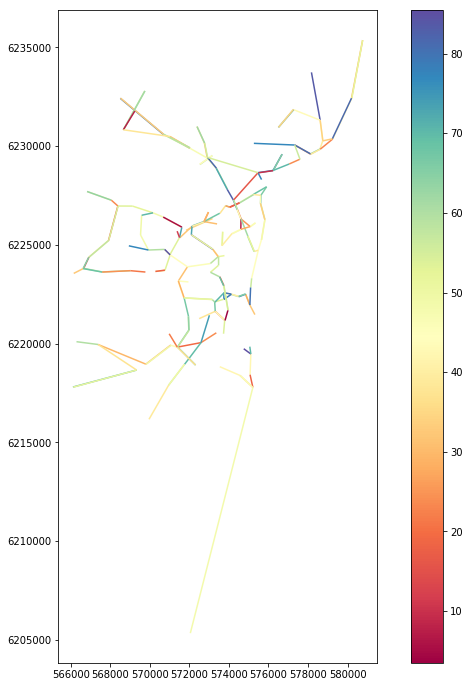

In [112]:
slow_down.plot('max_slow_down', legend=True, cmap='Spectral')
plt.savefig('max_slow_down_lines.svg')

In [113]:
fot_veje = geopandas.read_file('data/Shapefiles/fot_veje.shp') #bbox=(4320000,3660000,4340000,3680000)
fot_veje = fot_veje.to_crs(epsg=25832)

In [114]:
fot_veje = fot_veje[fot_veje.vej_type == 'Vej']

In [115]:
slow_down.geom_line = slow_down.geom_line.buffer(5)

In [91]:
#fot_veje.buffer(10)
print(fot_veje.crs, slow_down.crs)
#slow_down.to_crs(epsg=25832)

seonsor_veje = geopandas.sjoin(fot_veje, slow_down.loc[:,['_id','geom_line','max_slow_down']], how="inner", op='intersects')

{'init': 'epsg:25832', 'no_defs': True} {'init': 'epsg:25832', 'no_defs': True}


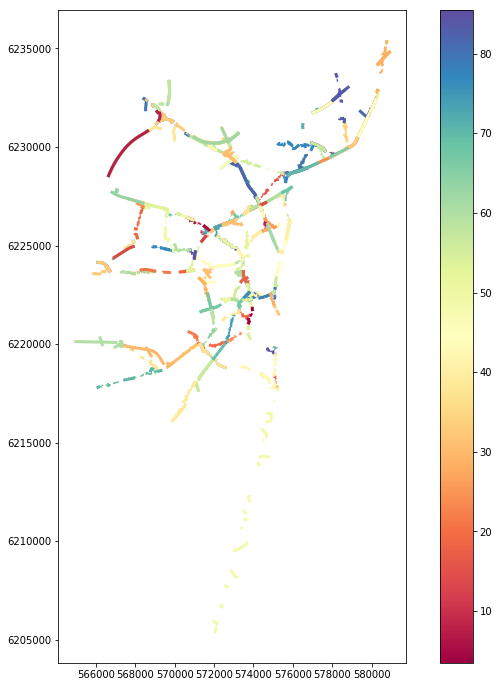

In [116]:
plot_seonsor_veje = seonsor_veje.plot('max_slow_down', legend=True, cmap='Spectral', linewidth=3)
plt.savefig('max_slow_down_joined_veje.svg')

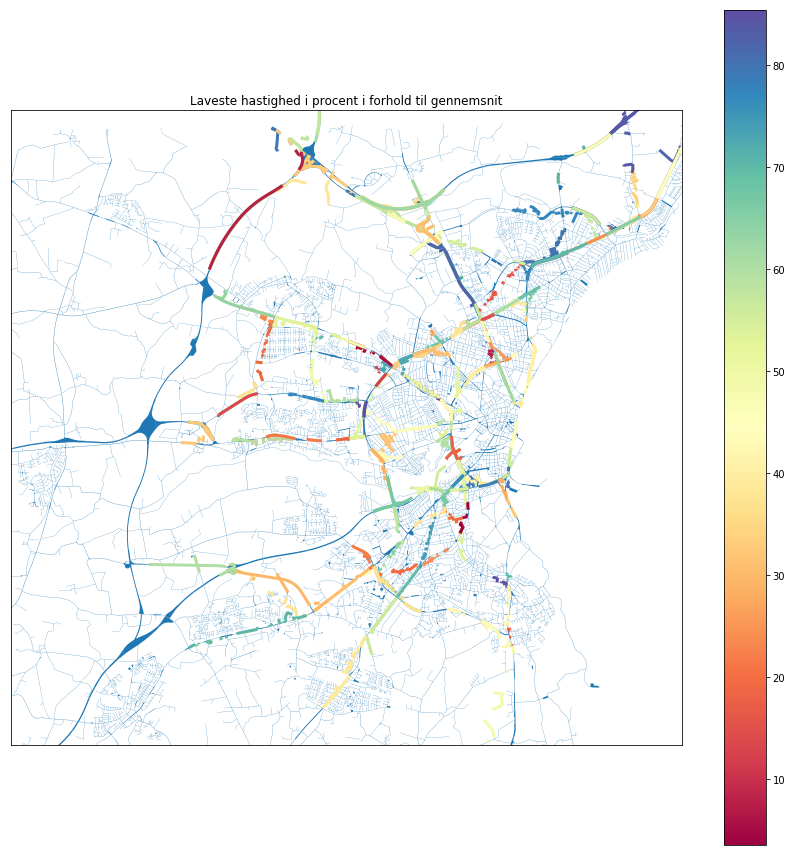

In [118]:
plot_roads = roads.to_crs(epsg=25832).plot(figsize=(12,12))
plot_roads.set_xlim(561000, 580000)
plot_roads.set_ylim(6215000, 6233000)
plot_roads.set_title('Laveste hastighed i procent i forhold til gennemsnit')

plt.xticks([])
plt.yticks([])
plot_seonsor_veje = seonsor_veje.plot(ax=plot_roads, column='max_slow_down', legend=True, cmap='Spectral', linewidth=3)
plt.tight_layout()
plt.savefig('aarhus_map_slow_down.svg')

# GeoPandas til Leaflet
Via folium

In [95]:
import folium
folium.__version__

'0.6.0'

In [119]:
print(list(seonsor_veje.total_bounds[[0,3]]))

m = folium.Map(location=[56.15, 10.2], zoom_start=11, tiles="cartodbpositron")

m.choropleth(
    geo_data=seonsor_veje,
    data=seonsor_veje,
    columns=['id','max_slow_down'],
    key_on='feature.properties._id',
    legend_name='Area (sq mi)', 
    fill_color='YlGn',
    fill_opacity=0.4,
    highlight=True)

m

[564907.91, 6235422.25]
